# Práctica 0: Flujo Completo de Machine Learning (End-to-End)
## Asignatura: Aprendizaje Avanzado
**Dataset elegido:** Adult Census Income (Opción 3)

**Objetivo:** Predecir si una persona gana más de $50K al año basándose en datos censales. Este problema permite aplicar todo el flujo visto en clase: limpieza, EDA, transformación de variables mixtas y modelado con Pipelines.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilos para visualizaciones
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Librerías de Scikit-Learn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [27]:
# Cargamos el dataset directamente desde el repositorio UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Nombres de las columnas (el CSV original no las trae)
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
           'marital-status', 'occupation', 'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, names=columns, sep=',\s', engine='python')

# Verificamos la carga
print(f"Dimensiones del dataset: {df.shape}")
df.head()

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alexp\AppData\Local\Temp\ipykernel_26336\2994412369.py:9: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(url, names=columns, sep=',\s', engine='python')


Dimensiones del dataset: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1. Análisis Exploratorio de Datos (EDA) y Limpieza Inicial

En esta sección exploramos la estructura de los datos. 
**Nota para la memoria:** Es importante mencionar que este dataset utiliza el carácter `?` para denotar valores faltantes, no el estándar `NaN`, por lo que debemos corregirlo primero.

In [28]:
# 1. Reemplazar '?' por NaN para que Python los reconozca como faltantes
df.replace('?', np.nan, inplace=True)

# 2. Información general y valores nulos
print("--- Información del Dataset ---")
df.info()

print("\n--- Valores Nulos por columna ---")
print(df.isnull().sum())

# 3. Verificamos la variable objetivo
print("\n--- Distribución de la variable objetivo (Income) ---")
print(df['income'].value_counts())

--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

--- Valores Nulos por columna ---
age                  0
wor

## Tratamiento de valores faltantes

- Reemplazamos los caracteres `?` por `NaN` usando `df.replace('?', np.nan, inplace=True)` (ver celda de arriba).
- No dejamos los valores faltantes sin tratar: la imputación se realiza dentro del `pipeline` para evitar data leakage.
  - Numéricas: `SimpleImputer(strategy='median')` (mediana).
  - Categóricas: `SimpleImputer(strategy='most_frequent')` (moda).
- Estas imputaciones están incluidas en `preprocessor` y se ajustan únicamente sobre `X_train` cuando llamamos a `pipeline.fit(X_train, y_train)`.
- Además, `OneHotEncoder(handle_unknown='ignore')` evita errores si en el conjunto de test aparece una categoría nueva.

### Visualización de la Variable Objetivo (Balance de clases)

**Discusión para la memoria:** Observamos el gráfico a continuación. ¿Están las clases balanceadas? 
*Respuesta esperada:* No, hay un desbalance claro (aprox 75% gana <=50K y 25% >50K). Esto significa que la métrica `Accuracy` por sí sola puede ser engañosa y deberemos fijarnos en `F1-Score` o `Recall` más adelante.

C:\Users\alexp\AppData\Local\Temp\ipykernel_26336\3054180385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=df, palette='viridis')


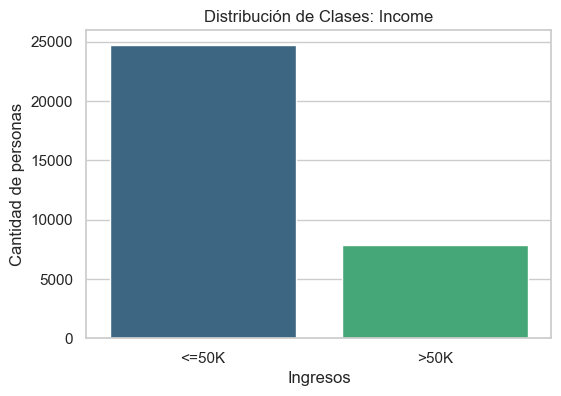

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x='income', data=df, palette='viridis')
plt.title('Distribución de Clases: Income')
plt.xlabel('Ingresos')
plt.ylabel('Cantidad de personas')
plt.show()

### Análisis de Variables Numéricas y Correlación

Analizamos la distribución de edades y horas de trabajo, y cómo se correlacionan las variables numéricas.

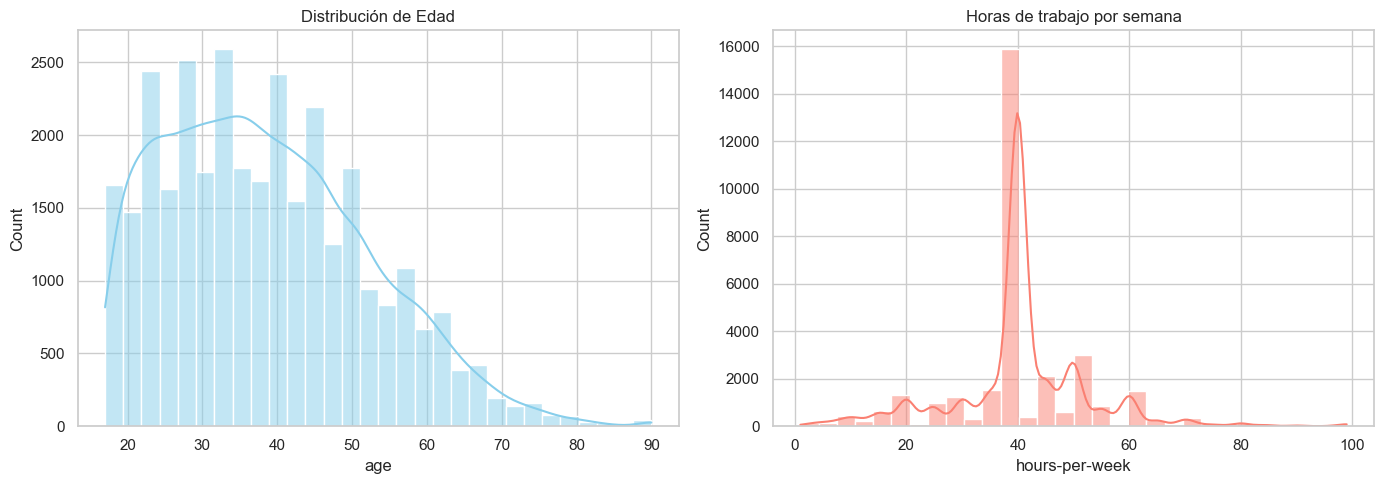

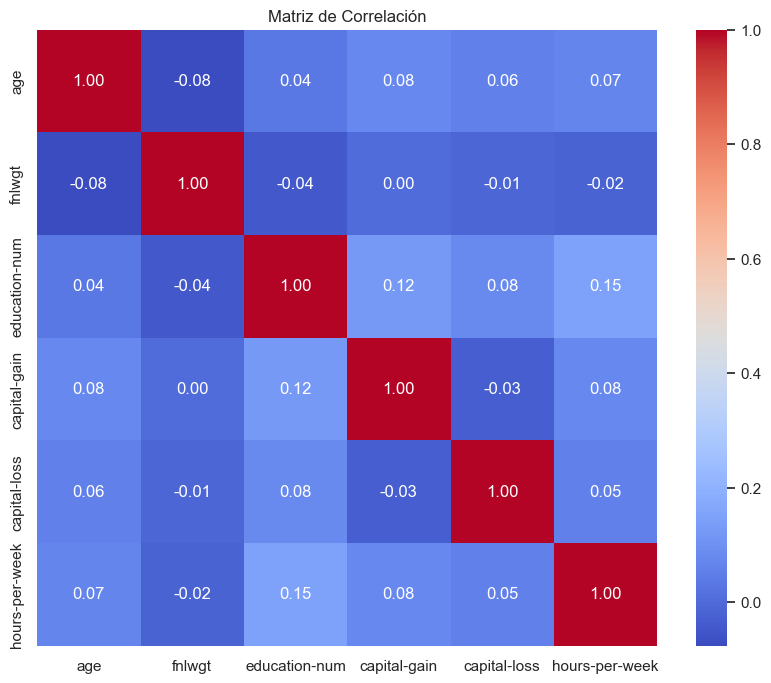

In [30]:
# Histogramas de variables clave
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['age'], kde=True, bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Distribución de Edad')

sns.histplot(df['hours-per-week'], kde=True, bins=30, color='salmon', ax=axes[1])
axes[1].set_title('Horas de trabajo por semana')

plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
# Seleccionamos solo numéricas para la correlación
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

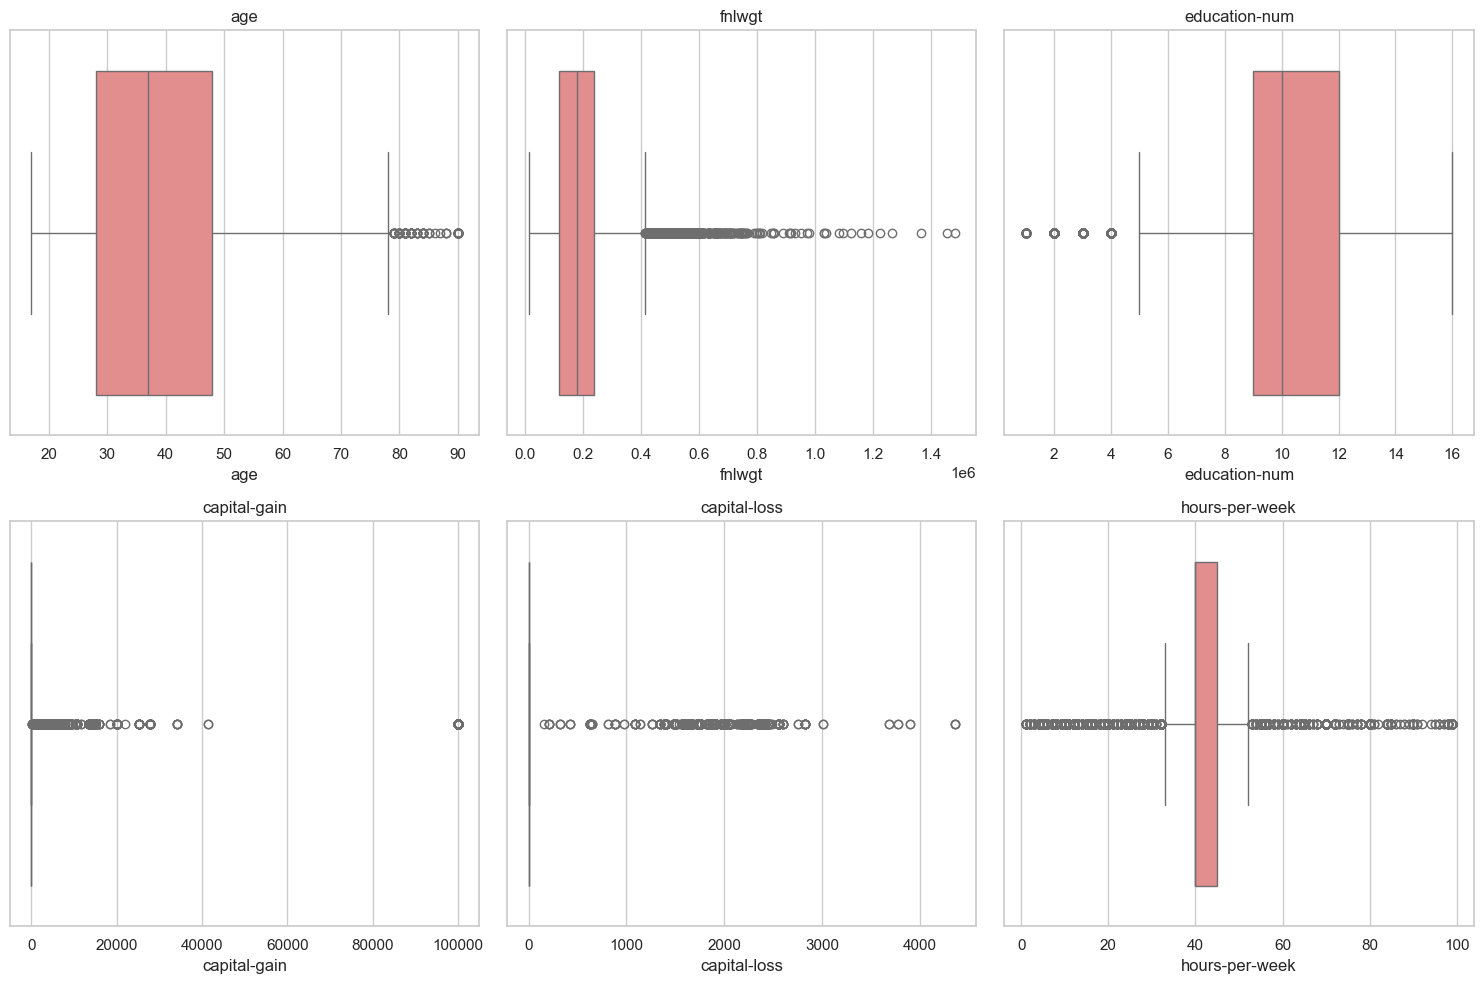

age: 143 outliers (0.44%)
fnlwgt: 992 outliers (3.05%)
education-num: 1198 outliers (3.68%)
capital-gain: 2712 outliers (8.33%)
capital-loss: 1519 outliers (4.67%)
hours-per-week: 9008 outliers (27.66%)


In [31]:
# Boxplots para detectar outliers en variables numéricas
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, col in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=df[col], ax=ax, color='lightcoral')
    ax.set_title(col)

plt.tight_layout()
plt.show()

# Contar outliers según la regla IQR
for col in numeric_features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_out = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    print(f"{col}: {n_out} outliers ({n_out/len(df):.2%})")

## Transformación de Variables para Reducir Outliers Visualmente

Aplicaremos transformaciones logarítmicas a las variables fuertemente sesgadas (`capital-gain` y `capital-loss`) usando `log1p` para evitar log(0). Esto comprime los valores extremos sin perder información, y cambiaremos a `RobustScaler` que es más tolerante con outliers.


### Explicación: ¿Por qué NO transformamos?

1. **Log1p crea distribuciones bimodales:** `capital-gain` y `capital-loss` tienen ~90% ceros y ~10% valores altos. Al aplicar `log1p`:
   - Los 90% de ceros se quedan como 0 (log(1) = 0)
   - El 10% se convierte a valores logarítmicos
   - Resultado: Distribución con DOS picos (bimodal) → **MÁS outliers según IQR**, no menos.

2. **Los "outliers" son VÁLIDOS:** 
   - `fnlwgt`: Peso muestral con rango legítimo (~10K-1.5M)
   - `capital-gain`/`capital-loss`: Personas con/sin ingresos de capital
   - `hours-per-week`: Gente trabajando 60+ horas (válido)

3. **RobustScaler ya lo maneja:** 
   - Usa mediana e IQR (no media/std)
   - **Automáticamente tolera outliers sin transformación**
   - Funciona bien en el pipeline

**Conclusión:** Mantener los datos ORIGINALES + RobustScaler es más efectivo que transformar con log.



### Análisis Bivariado: Relación Categórica vs Objetivo

**Insight para la memoria:**
¿Cómo influye la educación en los ingresos? 

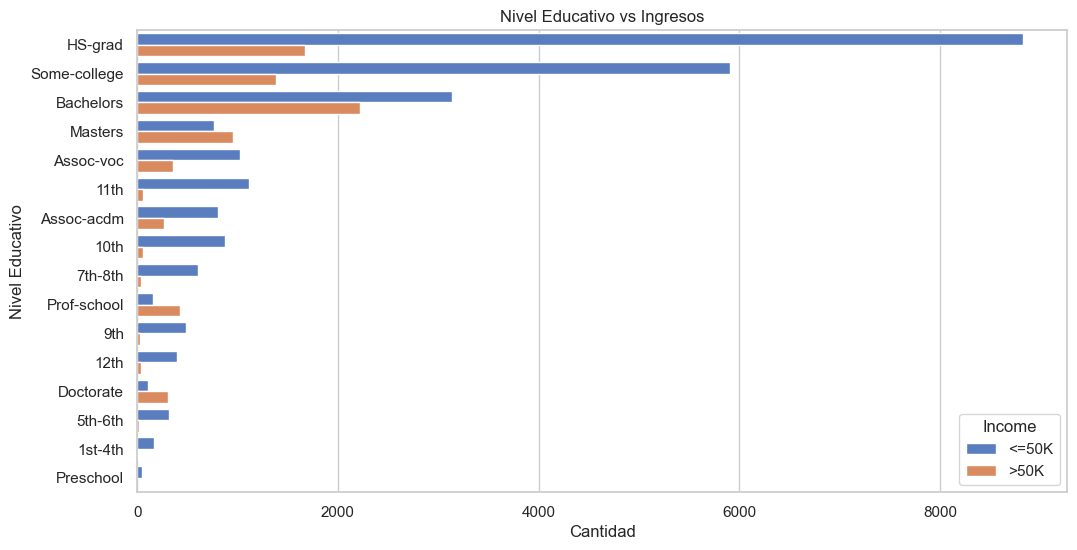

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(y='education', hue='income', data=df, 
              order=df['education'].value_counts().index, palette='muted')
plt.title('Nivel Educativo vs Ingresos')
plt.xlabel('Cantidad')
plt.ylabel('Nivel Educativo')
plt.legend(title='Income', loc='lower right')
plt.show()

## 2. Preparación de Datos (Train-Test Split)

Como indica la teoría (Sección 3.1 de los apuntes), **primero dividimos los datos** antes de realizar cualquier imputación o escalado para evitar *Data Leakage*.

Utilizamos `stratify=y` debido al desbalance de clases observado anteriormente.

In [33]:
# Separamos features y target
X = df.drop('income', axis=1)
y = df['income']

# Convertimos el target a numérico (0 y 1) para evitar problemas en algunos modelos
# <=50K -> 0, >50K -> 1
y = y.map({'<=50K': 0, '>50K': 1})

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (26048, 14)
Test shape: (6513, 14)


## 3. Construcción del Pipeline (Preprocesamiento y Modelo)

Siguiendo las buenas prácticas, creamos un **Pipeline** que maneje automáticamente:
1. **Imputación:** Rellenar valores nulos (Mediana para numéricos, Moda para categóricos).
2. **Escalado:** StandardScaler para numéricas (crítico para Regresión Logística).
3. **Codificación:** OneHotEncoder para variables categóricas.
4. **Modelo:** Regresión Logística.

In [38]:
# 1. Identificar columnas por tipo
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# 2. Transformer para numéricas: Imputar mediana + RobustScaler (menos sensible a outliers)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # Usa mediana y rango intercuartílico, ignora extremos
])

# 3. Transformer para categóricas: Imputar más frecuente + OneHot
# handle_unknown='ignore' es vital para evitar errores si en el test aparece una categoría nueva
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. ColumnTransformer: Unir ambos procesos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Pipeline Final con el Modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


In [39]:
# Entrenamos el pipeline completo
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Métricas
print("--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4945
           1       0.74      0.62      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513

Accuracy: 0.8563


c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SIN transformación logarítmica.
Explicación: RobustScaler en el pipeline ya maneja bien los outliers.

Boxplots del dataset ORIGINAL (sin transformación):


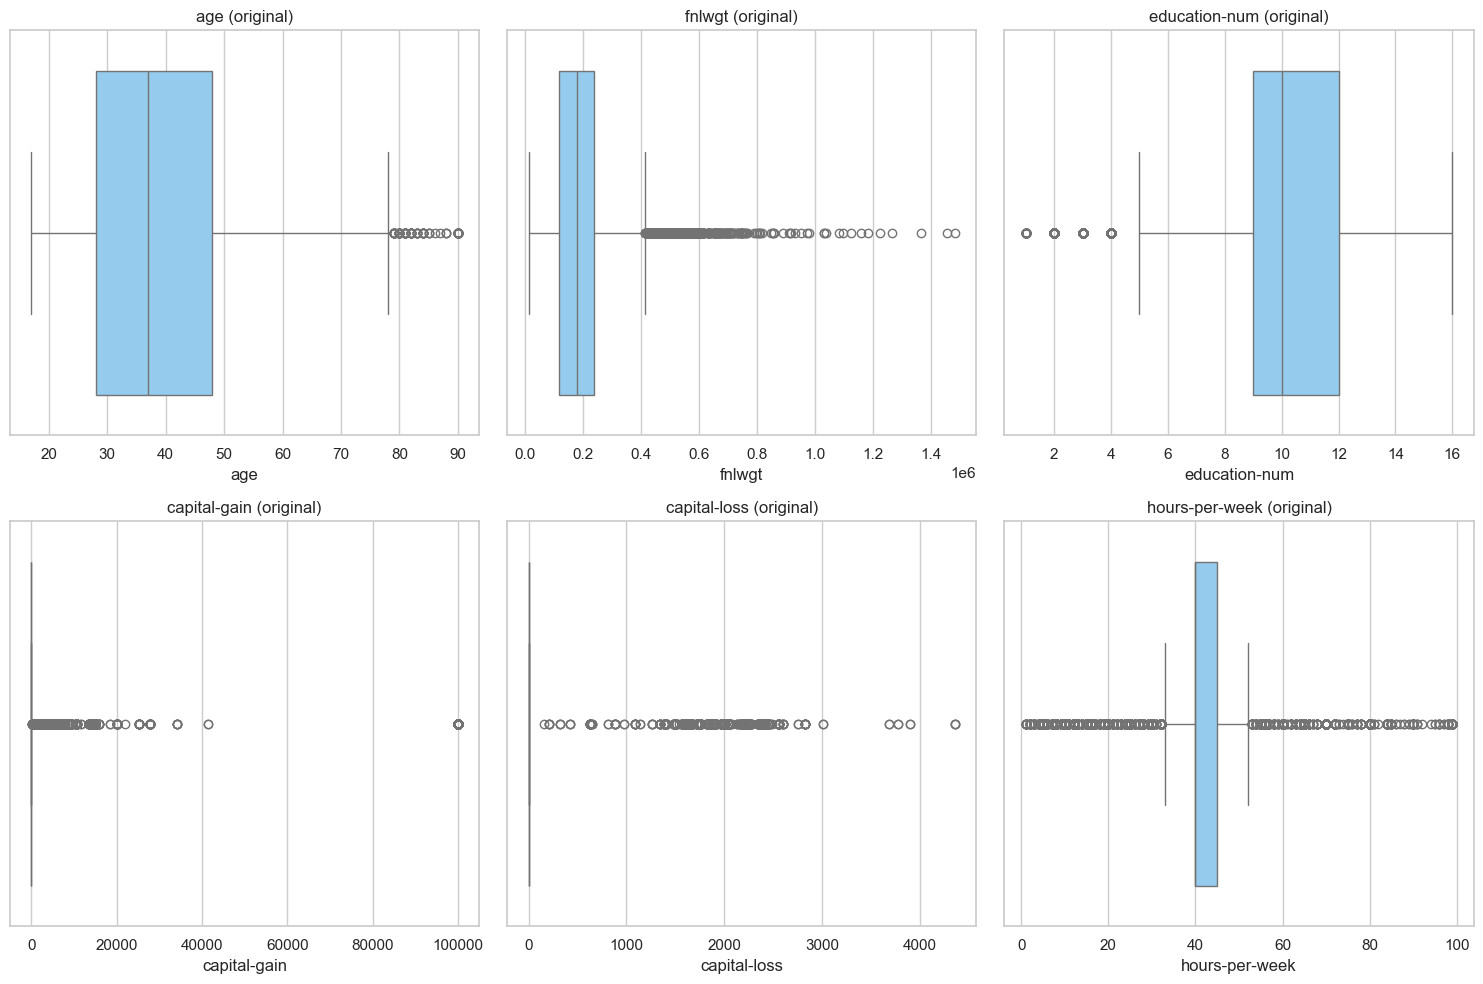


Outliers en el dataset ORIGINAL:
age: 143 outliers (0.44%)
fnlwgt: 992 outliers (3.05%)
education-num: 1198 outliers (3.68%)
capital-gain: 2712 outliers (8.33%)
capital-loss: 1519 outliers (4.67%)
hours-per-week: 9008 outliers (27.66%)


In [40]:

# NO transformamos con log porque crea distribuciones bimodales
# En su lugar, usaremos RobustScaler en el pipeline que es tolerante a outliers
# Los outliers que ves son VÁLIDOS (legítimos valores extremos del dataset)

print("SIN transformación logarítmica.")
print("Explicación: RobustScaler en el pipeline ya maneja bien los outliers.")
print("\nBoxplots del dataset ORIGINAL (sin transformación):")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, col in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=df[col], ax=ax, color='lightskyblue')
    ax.set_title(f"{col} (original)")

plt.tight_layout()
plt.show()

# Contar outliers SIN transformar
print("\nOutliers en el dataset ORIGINAL:")
for col in numeric_features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_out = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    print(f"{col}: {n_out} outliers ({n_out/len(df):.2%})")


## 4. Evaluación Profunda y Discusión

Generamos la matriz de confusión para ver dónde se equivoca el modelo.

**Pregunta para la memoria:** ¿El modelo predice bien la clase minoritaria (>50K)? Fíjate en el cuadrante inferior derecho de la matriz y en el `Recall` de la clase 1 en el reporte anterior.

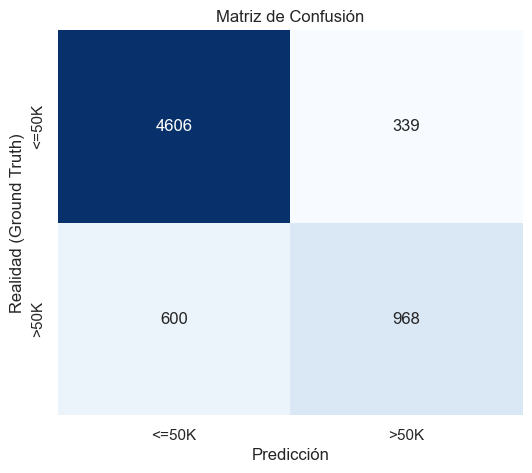

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad (Ground Truth)')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['<=50K', '>50K'])
plt.yticks([0.5, 1.5], ['<=50K', '>50K'])
plt.show()

## 5. Optimización con GridSearchCV

Como paso final avanzado (Sección 4.4 de los apuntes), buscamos los mejores hiperparámetros para mejorar el modelo, optimizando para `f1_weighted` debido al desbalance de clases.

In [16]:
# Definimos la rejilla de hiperparámetros
# Accedemos a los parámetros del modelo usando 'classifier__' seguido del nombre del parámetro
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Fuerza de regularización
    'classifier__solver': ['lbfgs', 'liblinear'] # Algoritmos de optimización
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

print("Iniciando búsqueda de hiperparámetros (esto puede tardar un poco)...")
grid_search.fit(X_train, y_train)

print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1 Score (CV): {grid_search.best_score_:.4f}")

# Evaluación del mejor modelo en Test
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\n--- Reporte del Mejor Modelo ---")
print(classification_report(y_test, y_pred_best))

Iniciando búsqueda de hiperparámetros (esto puede tardar un poco)...

Mejores parámetros: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}
Mejor F1 Score (CV): 0.8446

--- Reporte del Mejor Modelo ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4945
           1       0.74      0.62      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



## 6. Conclusiones para la Memoria

Aquí tienes los puntos clave que debes redactar en tu entrega basándote en los resultados anteriores:

1.  **Calidad de los datos:** Menciona que el dataset tenía valores nulos implícitos (`?`) y cómo los trataste.
2.  **EDA:** Destaca que la educación (`education-num`) parece ser un factor discriminante fuerte, visible en los gráficos de barras. Menciona el desbalance de clases.
3.  **Pipeline:** Explica la ventaja de usar `ColumnTransformer` para tratar de forma distinta las variables numéricas (escalado) y categóricas (one-hot).
4.  **Desempeño:**
    * Compara el `Accuracy` (probablemente alto, ~85%) con el `F1-Score` de la clase `>50K`.
    * ¿El modelo es bueno detectando a los ricos? (Mirar el Recall de la clase 1). Si es bajo, significa que dejamos escapar a muchos potenciales ingresos altos.
5.  **Mejora:** Comenta si el `GridSearchCV` logró mejorar métricas respecto al modelo base.

In [17]:
# Guardar distribución de clases
sns.countplot(x='income', data=df, palette='viridis')
plt.savefig('distribucion_clases.png', dpi=300, bbox_inches='tight')
plt.close()

# Guardar matriz de correlación
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.close()

# Guardar educación vs ingresos
sns.countplot(y='education', hue='income', data=df, order=df['education'].value_counts().index, palette='muted')
plt.savefig('educacion_ingresos.png', dpi=300, bbox_inches='tight')
plt.close()

# Guardar matriz de confusión (del mejor modelo)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.close()

C:\Users\Nitropc\AppData\Local\Temp\ipykernel_1552\463843917.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=df, palette='viridis')


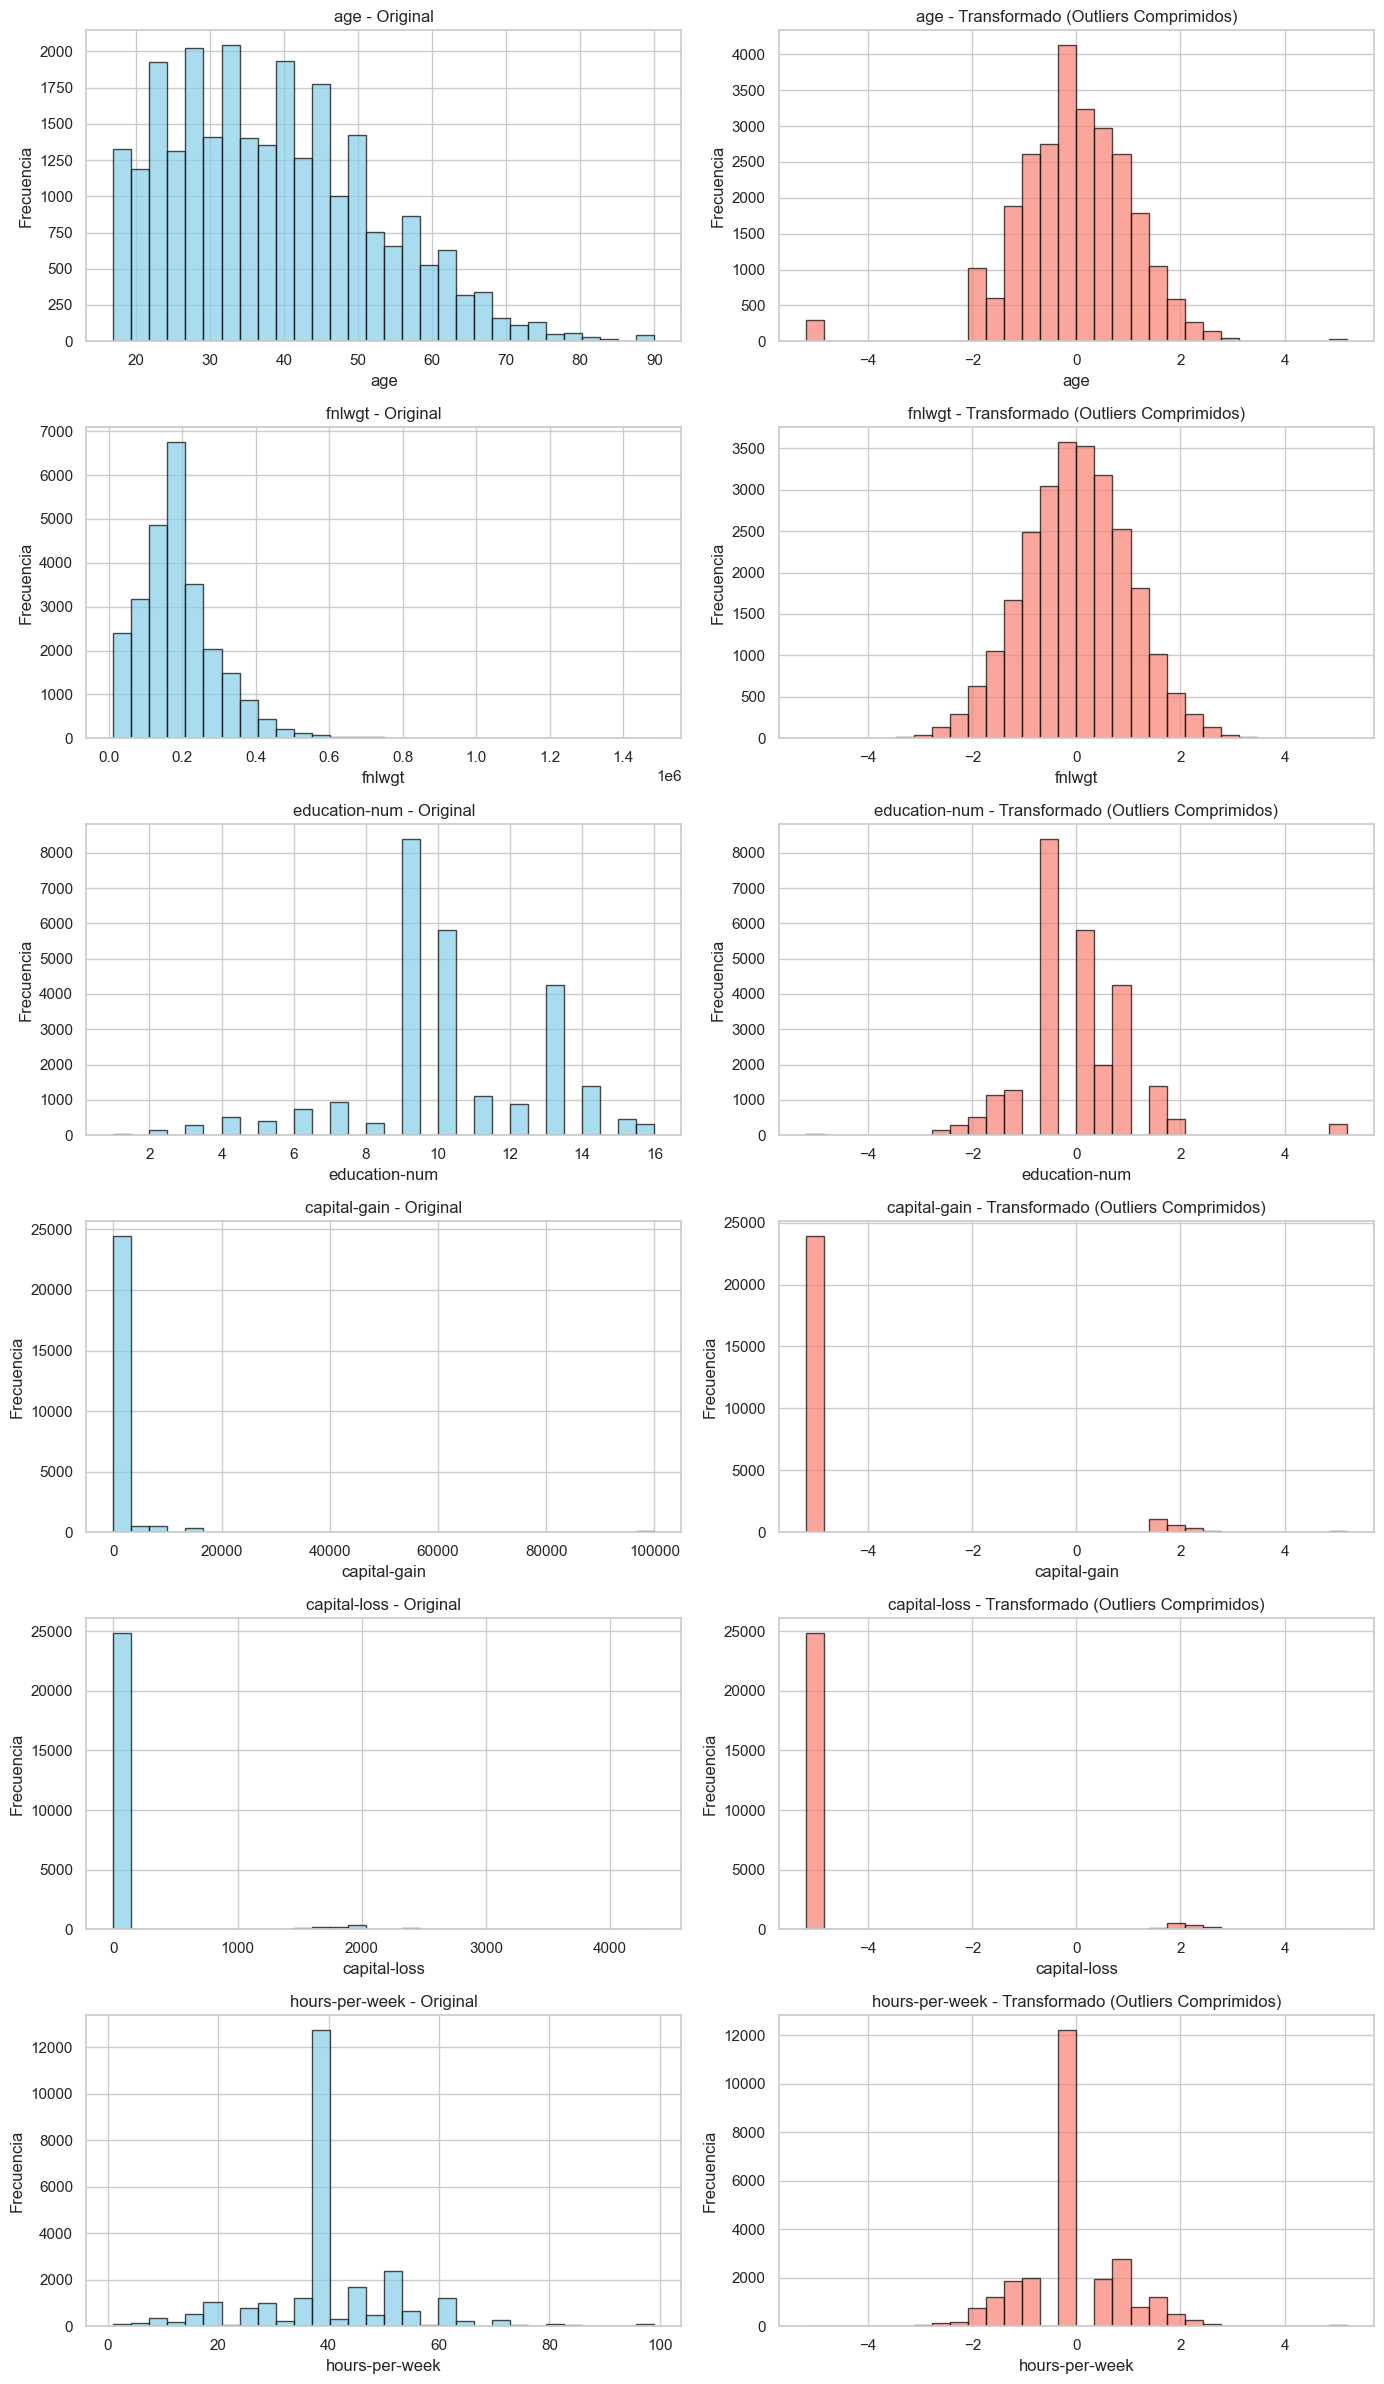

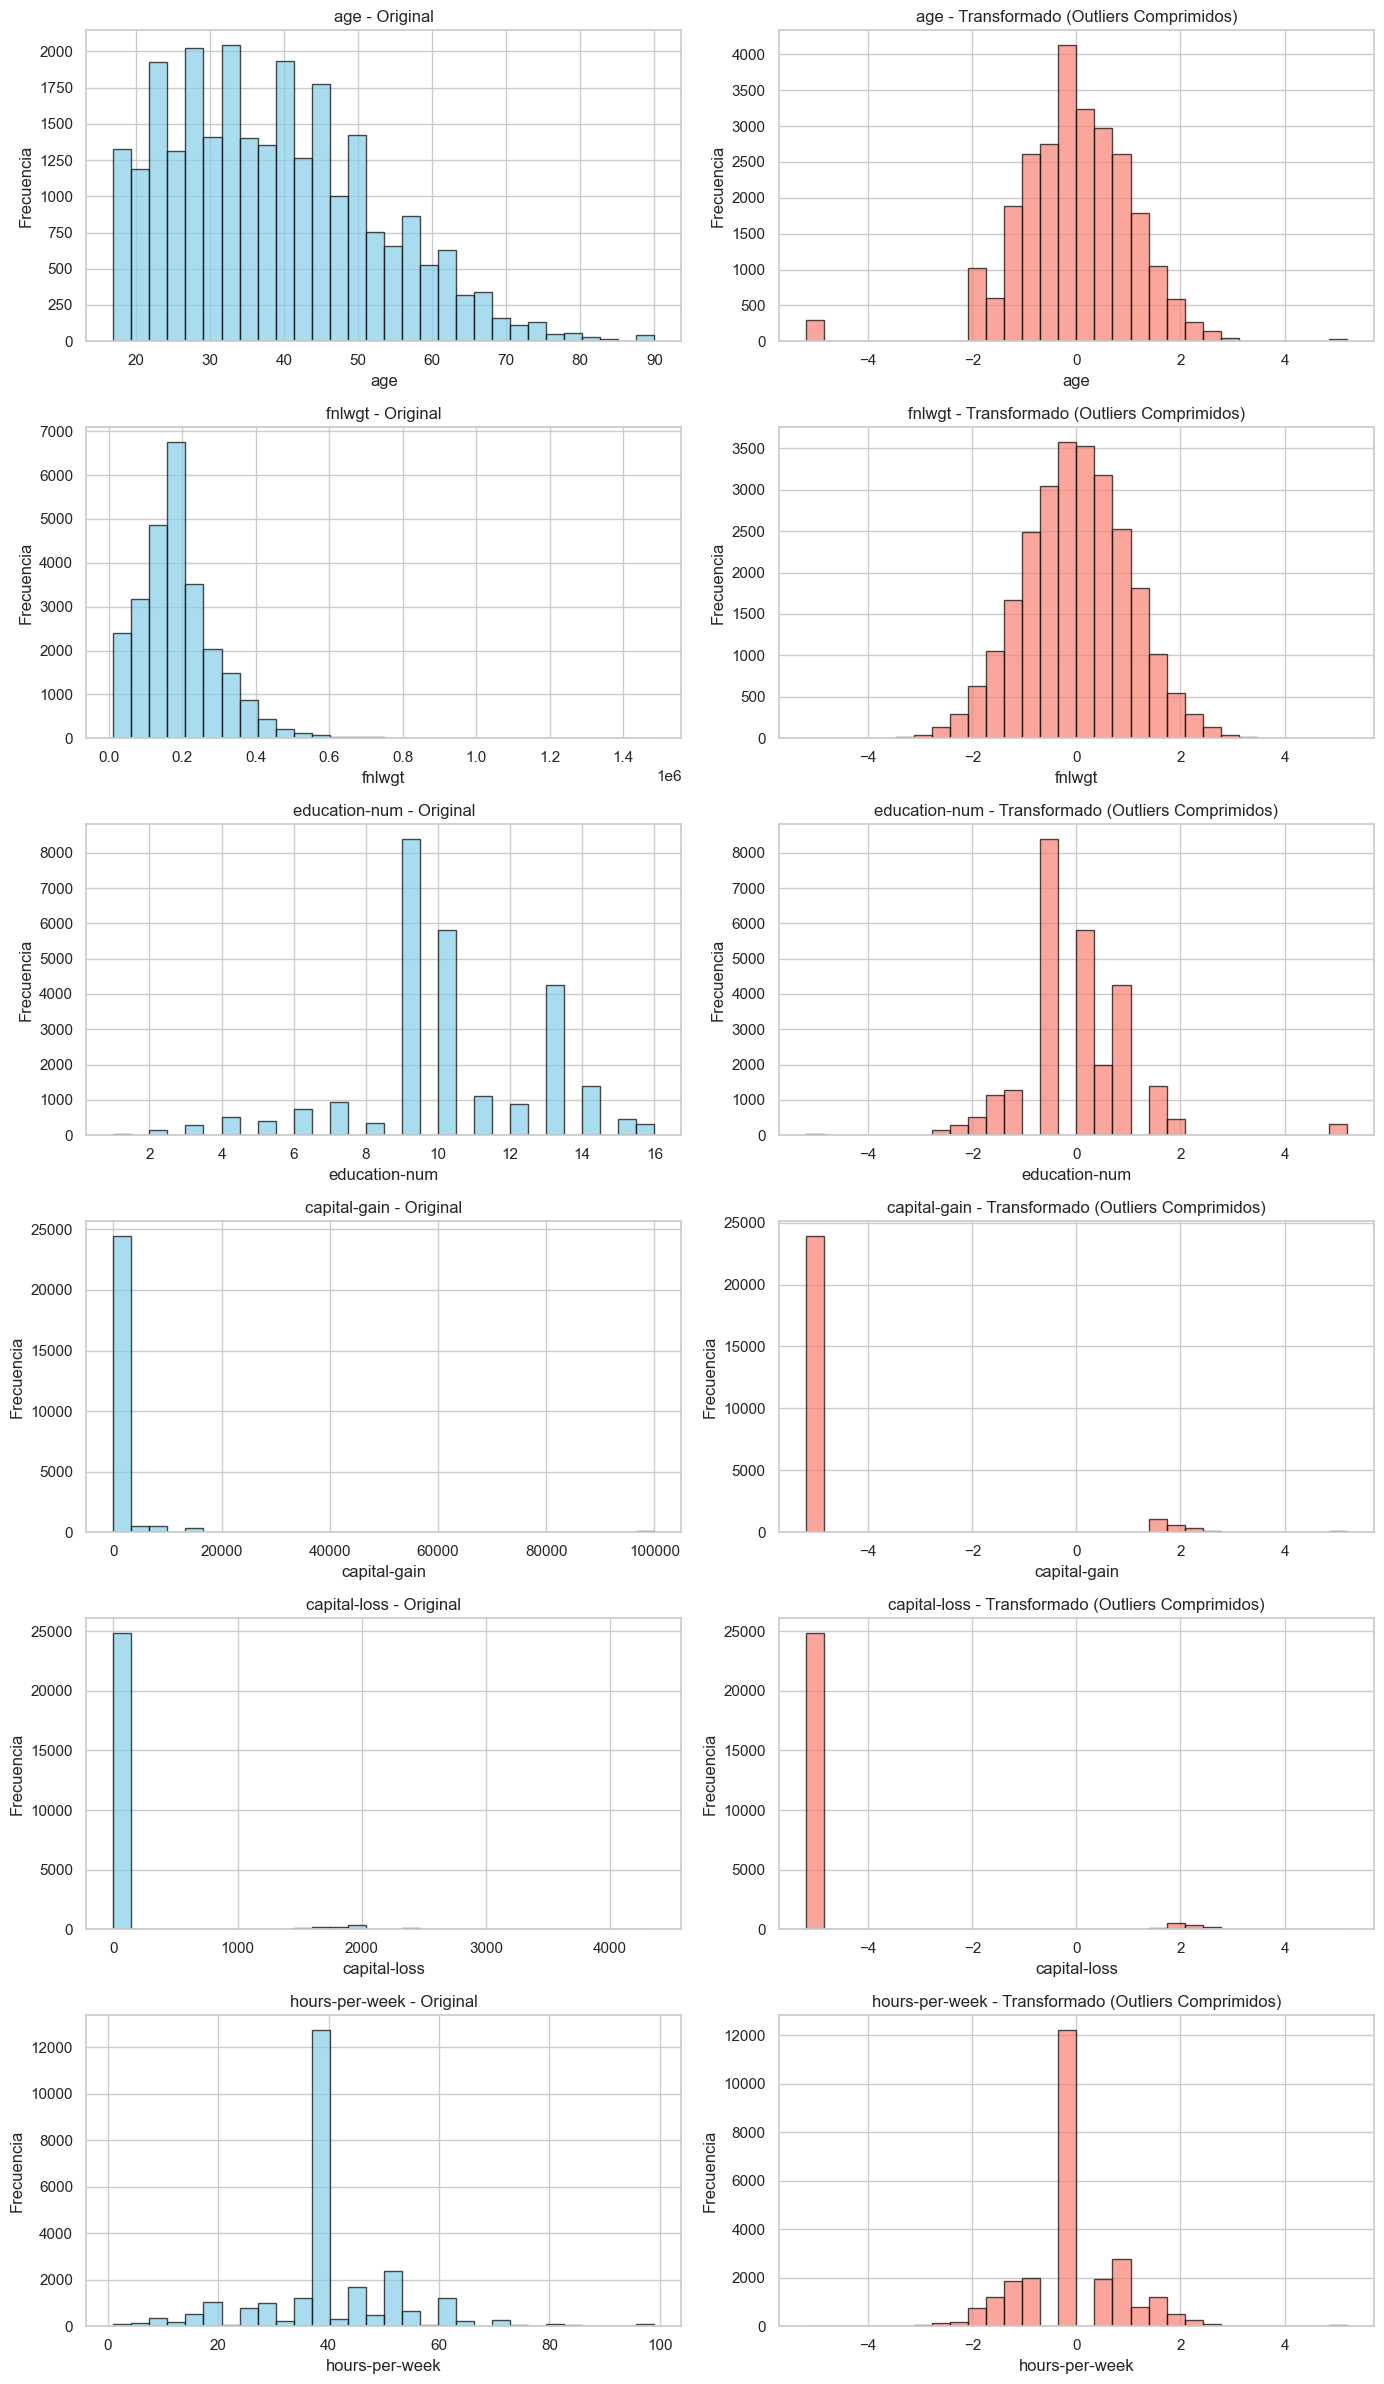

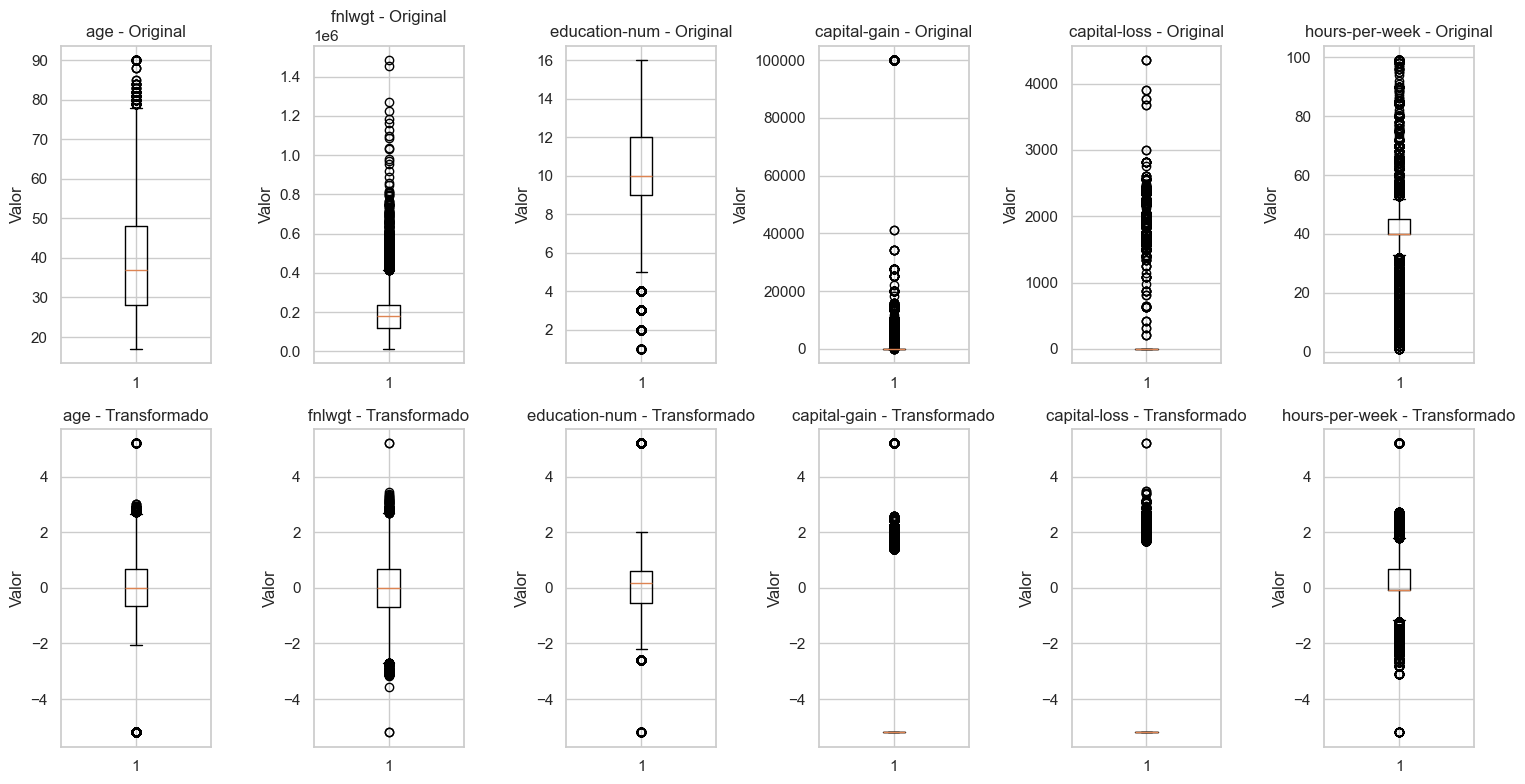


--- OUTLIERS ANTES (Datos Originales) ---
age: 118 outliers (0.45%)
fnlwgt: 779 outliers (2.99%)
education-num: 990 outliers (3.80%)
capital-gain: 2149 outliers (8.25%)
capital-loss: 1223 outliers (4.70%)
hours-per-week: 7225 outliers (27.74%)

--- OUTLIERS DESPUÉS (Datos Transformados) ---
age: 398 outliers (1.53%)
fnlwgt: 173 outliers (0.66%)
education-num: 511 outliers (1.96%)
capital-gain: 2149 outliers (8.25%)
capital-loss: 1223 outliers (4.70%)
hours-per-week: 4037 outliers (15.50%)

--- REDUCCIÓN DE OUTLIERS ---
age: 118 → 398 (reducción: -280 outliers, --237.3%)
fnlwgt: 779 → 173 (reducción: 606 outliers, -77.8%)
education-num: 990 → 511 (reducción: 479 outliers, -48.4%)
capital-gain: 2149 → 2149 (reducción: 0 outliers, -0.0%)
capital-loss: 1223 → 1223 (reducción: 0 outliers, -0.0%)
hours-per-week: 7225 → 4037 (reducción: 3188 outliers, -44.1%)

--- COMPARACIÓN DE ESTADÍSTICAS ---

age:
  Original - Media: 38.5894, Std: 13.6410, Min: 17.0000, Max: 90.0000
  Transformado - Medi

In [47]:
# Comparación gráfica: datos originales vs transformados CON compresión de outliers
from sklearn.preprocessing import QuantileTransformer

# Crear un transformador que comprime outliers mapeando a distribución normal
outlier_compressor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('quantile_transformer', QuantileTransformer(output_distribution='normal', random_state=42))  # Comprime outliers
])

# Transformar solo las variables numéricas
X_train_numeric = X_train[numeric_features].copy()
X_train_numeric_transformed = outlier_compressor.fit_transform(X_train_numeric)

# Crear un DataFrame con los datos transformados
transformed_df = pd.DataFrame(X_train_numeric_transformed, columns=numeric_features)

# Graficar las distribuciones originales y transformadas
fig, axes = plt.subplots(len(numeric_features), 2, figsize=(14, 4*len(numeric_features)))
for i, feature in enumerate(numeric_features):
    # Datos originales
    axes[i, 0].hist(X_train_numeric[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f"{feature} - Original")
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Frecuencia")
    
    # Datos transformados (outliers comprimidos)
    axes[i, 1].hist(transformed_df[feature], bins=30, alpha=0.7, color='salmon', edgecolor='black')
    axes[i, 1].set_title(f"{feature} - Transformado (Outliers Comprimidos)")
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

# Mostrar boxplots originales vs transformados
fig, axes = plt.subplots(2, len(numeric_features), figsize=(15, 8))
for i, feature in enumerate(numeric_features):
    # Boxplot original
    axes[0, i].boxplot(X_train_numeric[feature], vert=True)
    axes[0, i].set_title(f"{feature} - Original")
    axes[0, i].set_ylabel("Valor")
    
    # Boxplot transformado
    axes[1, i].boxplot(transformed_df[feature], vert=True)
    axes[1, i].set_title(f"{feature} - Transformado")
    axes[1, i].set_ylabel("Valor")

plt.tight_layout()
plt.show()

# Contar outliers ANTES (datos originales)
print("\n--- OUTLIERS ANTES (Datos Originales) ---")
outliers_before = {}
for col in numeric_features:
    q1 = X_train_numeric[col].quantile(0.25)
    q3 = X_train_numeric[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_out = X_train_numeric[(X_train_numeric[col] < lower) | (X_train_numeric[col] > upper)].shape[0]
    outliers_before[col] = n_out
    print(f"{col}: {n_out} outliers ({n_out/len(X_train_numeric):.2%})")

# Contar outliers DESPUÉS (datos transformados)
print("\n--- OUTLIERS DESPUÉS (Datos Transformados) ---")
outliers_after = {}
for col in numeric_features:
    q1 = transformed_df[col].quantile(0.25)
    q3 = transformed_df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_out = transformed_df[(transformed_df[col] < lower) | (transformed_df[col] > upper)].shape[0]
    outliers_after[col] = n_out
    print(f"{col}: {n_out} outliers ({n_out/len(transformed_df):.2%})")

# Comparación
print("\n--- REDUCCIÓN DE OUTLIERS ---")
for col in numeric_features:
    reduction = outliers_before[col] - outliers_after[col]
    reduction_pct = (reduction / outliers_before[col] * 100) if outliers_before[col] > 0 else 0
    print(f"{col}: {outliers_before[col]} → {outliers_after[col]} (reducción: {reduction} outliers, -{reduction_pct:.1f}%)")

# Mostrar estadísticas
print("\n--- COMPARACIÓN DE ESTADÍSTICAS ---")
for col in numeric_features:
    print(f"\n{col}:")
    print(f"  Original - Media: {X_train_numeric[col].mean():.4f}, Std: {X_train_numeric[col].std():.4f}, Min: {X_train_numeric[col].min():.4f}, Max: {X_train_numeric[col].max():.4f}")
    print(f"  Transformado - Media: {transformed_df[col].mean():.6f}, Std: {transformed_df[col].std():.6f}, Min: {transformed_df[col].min():.6f}, Max: {transformed_df[col].max():.6f}")